In [1]:
import pinot
from pinot.net import Net
from pinot import data
import torch
import dgl
import pyro
import pylab as plt

Using backend: pytorch


In [2]:
ds = pinot.data.moonshot_mixed()
view = ds.view('all_available_pairs', batch_size=1)

In [3]:
def fractional_saturation(delta_g=None, concentration=1e-3):
    """
    concentration: scalar in Molar
    delta_g: unit_less binding energy
    """
    return 1.0 / (1.0 + torch.exp(delta_g)/concentration)

In [4]:
def sample_measurement(delta_g=None, concentration=1e-3):
    """
    concentration: scalar in Molar
    delta_g: unit_less binding energy
    """
    fs = fractional_saturation(delta_g,concentration)
    mu_binding = (fs)*100
    sigma_binding = torch.ones(1) * 1
    dist_mu = pyro.distributions.Normal(mu_binding,sigma_binding)
    ms = pyro.sample("measurement at concentration {}".format(concentration),dist_mu,obs=None)
    return ms

In [5]:
# c_list = torch.arange(0,100e-6,1e-6)
# g_list = torch.arange(-5,5,100)

In [6]:
def kd_to_delta_g(kd=None):
    delta_g = torch.log(kd)
    return delta_g

def delta_g_to_kd(delta_g=None):
    kd = torch.exp(delta_g)
    return kd

In [7]:
def curve_sample(dg_example=None, c_list = None):
    if c_list==None:
        c_list = torch.arange(0,100e-6,1e-6)
    m_collection = []
    for iic in range(len(c_list)):
        con = c_list[iic]
        m_iic=sample_measurement(delta_g=dg_example,concentration=con)
        m_collection.append(m_iic.detach().numpy())
    return m_collection

In [8]:
def curve_mu(dg_example=None, c_list=None):
    if c_list==None:
        c_list = torch.arange(0,100e-6,1e-6)
    m_collection = []
    for iic in range(len(c_list)):
        con = c_list[iic]
        sat_iic=fractional_saturation(delta_g=dg_example,concentration=con)
        m_iic = (sat_iic) * 100
        m_collection.append(m_iic.detach().numpy())
    return m_collection

# <b> Example borrowed from https://www.molbiolcell.org/doi/10.1091/mbc.e10-08-0683 Fig.4 <b>

In [9]:
#  presence Kd ∼ 0.05 μM) or absence (□; Kd = 0.25 μM)
delta_g_presence = kd_to_delta_g(0.05 * torch.ones(1)*1e-6)
delta_g_absence = kd_to_delta_g(0.25 * torch.ones(1)*1e-6)
delta_gs = [delta_g_presence,delta_g_absence]

Text(0.5, 0, 'concentration in M')

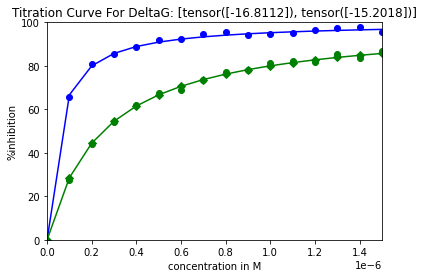

In [10]:
# a list of concentrations in range
c_list = torch.arange(0,1.5e-6,1e-7)

tc_m_presence = curve_mu(delta_g_presence,c_list)
tc_s_presence = curve_sample(delta_g_presence,c_list)


tc_m_absence = curve_mu(delta_g_absence,c_list)
tc_s_absence = curve_sample(delta_g_absence,c_list)


# plt.plot(c_list,tc_m_presence,'s',color='blue')
plt.plot(c_list,tc_m_presence,color='blue')
plt.plot(c_list,tc_s_presence,'o',color='blue')


plt.plot(c_list,tc_m_absence,'D',color='green')
plt.plot(c_list,tc_m_absence,color='green')
plt.plot(c_list,tc_s_absence,'o',color='green')

plt.title("Titration Curve For DeltaG: {}".format(delta_gs))
plt.xlim([0,c_list[-1]])
plt.ylim([0,100])
plt.ylabel('%inhibition')
plt.xlabel('concentration in M')


# Example Fig. 3

In [11]:
#  presence Kd ∼ 0.05 μM) or absence (□; Kd = 0.25 μM)
delta_g_binding = kd_to_delta_g(1. * torch.ones(1)*1e-6)

Text(0.5, 0, 'concentration in M')

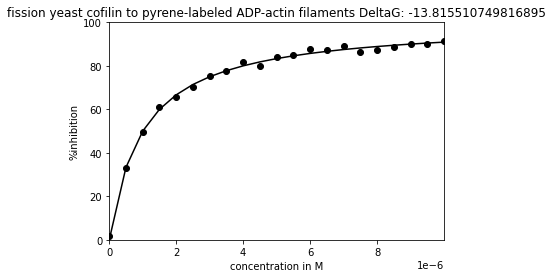

In [12]:
# a list of concentrations in range
c_list = torch.arange(0,10e-6,5e-7)

tc_m_binding = curve_mu(delta_g_binding,c_list)
tc_s_binding = curve_sample(delta_g_binding,c_list)

# plt.plot(c_list,tc_m_binding,'s',color='black')
plt.plot(c_list,tc_m_binding,color='black')
plt.plot(c_list,tc_s_binding,'o',color='black')


plt.title("fission yeast cofilin to pyrene-labeled ADP-actin filaments DeltaG: {}".format(delta_g_binding.item()))
plt.xlim([0,c_list[-1]])
plt.ylim([0,100])
plt.ylabel('%inhibition')
plt.xlabel('concentration in M')


# poly-L-proline oligomers to profilin Fig. 2 

Text(0.5, 0, 'concentration in M')

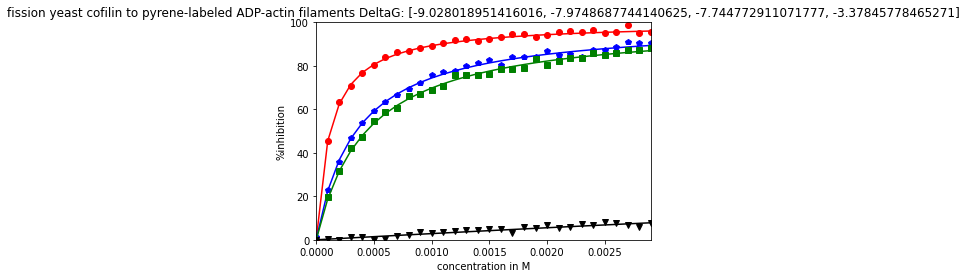

In [15]:
delta_g1 = kd_to_delta_g(torch.ones(1)*1e-6*433)
delta_g2 = kd_to_delta_g(torch.ones(1)*1e-6*344)
delta_g3 = kd_to_delta_g(torch.ones(1)*1e-6*120)
delta_g0 = kd_to_delta_g(torch.ones(1)*1e-3*34.1)
delta_gs = [delta_g3,delta_g2,delta_g1,delta_g0]

c_list = torch.arange(0,3000e-6,100e-6)

tc_m1 = curve_mu(delta_g1,c_list)
tc_s1 = curve_sample(delta_g1,c_list)

tc_m2 = curve_mu(delta_g2,c_list)
tc_s2 = curve_sample(delta_g2,c_list)

tc_m3 = curve_mu(delta_g3,c_list)
tc_s3 = curve_sample(delta_g3,c_list)

tc_m0 = curve_mu(delta_g0,c_list)
tc_s0 = curve_sample(delta_g0,c_list)


plt.plot(c_list,tc_m3,color='red')
plt.plot(c_list,tc_s3,'o',color='red')

plt.plot(c_list,tc_m2,color='blue')
plt.plot(c_list,tc_s2,'p',color='blue')

plt.plot(c_list,tc_m1,color='green')
plt.plot(c_list,tc_s1,'s',color='green')

plt.plot(c_list,tc_m0,color='black')
plt.plot(c_list,tc_s0,'v',color='black')


plt.title("fission yeast cofilin to pyrene-labeled ADP-actin filaments DeltaG: {}".format([delta_gs[i].item() for i in range(4)]))
plt.xlim([0,c_list[-1]])
plt.ylim([0,100])
plt.ylabel('%inhibition')
plt.xlabel('concentration in M')

# Heavy tailed Noise Models: Student-T

In [14]:
def sample_measurement(delta_g=None, concentration=1e-3):
    """
    concentration: scalar in Molar
    delta_g: unit_less binding energy
    """
    fs = fractional_saturation(delta_g,concentration)
    mu_binding = (fs)*100
    sigma_binding = torch.ones(1) * 1
    dist_mu = pyro.distributions.StudentT(df=1,loc=mu_binding,scale=sigma_binding)
    ms = pyro.sample("measurement at concentration {}".format(concentration),dist_mu,obs=None)
    return ms

Text(0.5, 0, 'concentration in M')

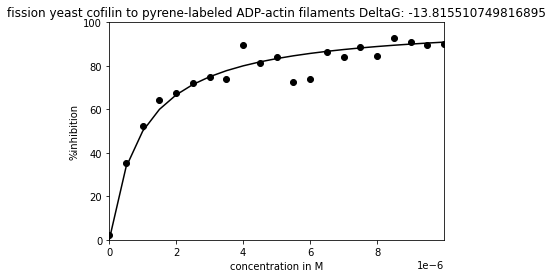

In [15]:
#  presence Kd ∼ 0.05 μM) or absence (□; Kd = 0.25 μM)
delta_g_binding = kd_to_delta_g(1. * torch.ones(1)*1e-6)
# a list of concentrations in range
c_list = torch.arange(0,10e-6,5e-7)

tc_m_binding = curve_mu(delta_g_binding,c_list)
tc_s_binding = curve_sample(delta_g_binding,c_list)

# plt.plot(c_list,tc_m_binding,'s',color='black')
plt.plot(c_list,tc_m_binding,color='black')
plt.plot(c_list,tc_s_binding,'o',color='black')


plt.title("fission yeast cofilin to pyrene-labeled ADP-actin filaments DeltaG: {}".format(delta_g_binding.item()))
plt.xlim([0,c_list[-1]])
plt.ylim([0,100])
plt.ylabel('%inhibition')
plt.xlabel('concentration in M')